<a href="https://colab.research.google.com/github/KassenBoyaubay/MPA-MLF-Exercises/blob/main/Finalproject/Finalproject_Colab_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MPA-MLF, Finalproject
### *Kassen Boyaubay*

## 0. Import libraries

In [8]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# from keras import regularizers
# from sklearn import preprocessing
# from sklearn import decomposition
# from sklearn.svm import LinearSVC
# from numpy import argmax

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Mount Files

In [13]:
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir_csv = os.path.join(base_dir, 'Train/CSV/')
x_test_dir_csv = os.path.join(base_dir, 'Test/CSV/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data examination

### 2.1 Size of the dataset

In [14]:
print('total training images:', len(os.listdir(x_train_dir_csv)))
print('total test images:', len(os.listdir(x_test_dir_csv)))

total training images: 8279
total test images: 3549


### 2.2 Explore the dataset

In [22]:
img_name = 'img_0'
img = pd.read_csv('/content/drive/MyDrive/Dataset/Train/CSV/' + img_name + '.csv').values
print('Image shape: ', img.shape)
print(img)

img = np.delete(img, 0, 1)
print('Image shape without first column: ', img.shape)
print(img)

Image shape:  (44, 52)
[[  0.      40.809   25.751  ... 104.78    51.486    7.3866]
 [  1.      35.794   24.56   ...  79.366   56.694   63.145 ]
 [  2.      16.8     14.145  ...  31.332   24.686   21.428 ]
 ...
 [ 41.      62.486   74.848  ...  23.319   59.134   64.447 ]
 [ 42.      11.689   13.603  ...  22.591   43.078   32.451 ]
 [ 43.      80.212   27.695  ...  60.717   30.785   82.938 ]]
Image shape without first column:  (44, 51)
[[ 40.809   25.751   89.378  ... 104.78    51.486    7.3866]
 [ 35.794   24.56    37.289  ...  79.366   56.694   63.145 ]
 [ 16.8     14.145   51.555  ...  31.332   24.686   21.428 ]
 ...
 [ 62.486   74.848   41.44   ...  23.319   59.134   64.447 ]
 [ 11.689   13.603   60.658  ...  22.591   43.078   32.451 ]
 [ 80.212   27.695   17.801  ...  60.717   30.785   82.938 ]]


Text(0.5, 1.0, 'img_0')

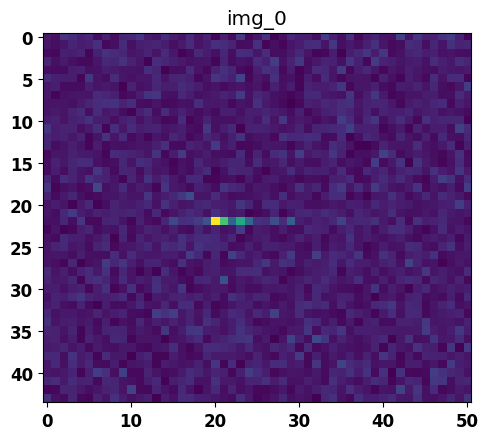

In [23]:
plt.imshow(img)
plt.title(img_name)

### 2.3 Explore the labels

In [3]:
y_train = pd.read_csv(y_train_dir)
print(y_train.iloc[0:4])
print('y_train shape:', y_train.shape)
print('\ny_train unique values:', y_train['target'].unique())
print('labels:', len(y_train['target'].unique()))

   id  target
0   0       1
1   1       3
2   2       1
3   3       1
y_train shape: (8279, 2)

y_train unique values: [1 3 2]
labels: 3


## 3. Data preprocessing

### 3.1 x_train preprocessing

In [ ]:
x_train = []
for filename in os.listdir(x_train_dir_csv):
  a = pd.read_csv(os.path.join(x_train_dir_csv, filename)).values
  a = np.delete(a, 0, 1)
  x_train.append(a)
x_train = np.array(x_train)
print(x_train.shape)

(8279, 50, 50, 3)


#### Save x_train

In [11]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_train_csv.npz', x_train)

#### Load x_train

In [52]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_train_csv.npz')
# extract the first array
x_train = dict_data['arr_0']

### 3.2 x_test preprocessing

In [ ]:
x_test = []
for filename in os.listdir(x_test_dir_csv):
  a = pd.read_csv(os.path.join(x_test_dir_csv, filename)).values
  a = np.delete(a, 0, 1)
  x_test.append(a)
x_test = np.array(x_test)
print(x_test.shape)

(3562, 50, 50, 3)


#### Save x_test

In [12]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_test_csv.npz', x_test)

#### Load x_test

In [53]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_test_csv.npz')
# extract the first array
x_test = dict_data['arr_0']

#### 3.3 Normalize x_train and x_test

In [ ]:
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

OR

In [32]:
Xscaler = MinMaxScaler()

In [37]:
for id, (x_train_data, x_test_data) in enumerate(zip(x_train, x_test)):
  x_train_scaled=Xscaler.fit_transform(x_train_data)
  x_test_scaled=Xscaler.fit_transform(x_test_data)
  x_train[id]=x_train_scaled
  x_test[id]=x_test_scaled

### 3.4 y_train preprocessing

In [39]:
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
print('"target" values as array: ', y_train['target'].values)
print('one-hot encoded: \n', y_train_encoded)

"target" values as array:  [1 3 1 ... 2 1 2]
one-hot encoded: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


### 3.5 train test split

## 4. MLP model

### 4.1 Build MLP model

In [48]:
input_shape = (44, 51)

model = Sequential(
    [
        Input(shape=input_shape),
     
        layers.Flatten(),
     
        layers.Dense(512, activation="gelu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(256, activation="gelu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(128, activation="gelu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2244)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1149440   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,314,051
Trainable params: 1,314,051
Non-trainable params: 0
_________________________________________________________________


### 4.2 Train CNN model

In [44]:
callbacks = [
        EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1)
]

In [56]:
batch_size = 64
epochs = 100

optimizer = Adam(
    learning_rate=0.01,
)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=2)

Epoch 1/100
104/104 - 3s - loss: 1.4995 - accuracy: 0.4447 - val_loss: 8056.1255 - val_accuracy: 0.2649 - 3s/epoch - 31ms/step
Epoch 2/100
104/104 - 3s - loss: 1.0689 - accuracy: 0.4518 - val_loss: 1979.2991 - val_accuracy: 0.4501 - 3s/epoch - 27ms/step
Epoch 3/100
104/104 - 2s - loss: 1.0690 - accuracy: 0.4518 - val_loss: 1691.7938 - val_accuracy: 0.4501 - 2s/epoch - 21ms/step
Epoch 4/100
104/104 - 2s - loss: 1.0685 - accuracy: 0.4510 - val_loss: 1307.9453 - val_accuracy: 0.4501 - 2s/epoch - 16ms/step
Epoch 5/100
104/104 - 3s - loss: 1.0685 - accuracy: 0.4518 - val_loss: 111.4694 - val_accuracy: 0.4501 - 3s/epoch - 28ms/step
Epoch 6/100
104/104 - 2s - loss: 1.0679 - accuracy: 0.4518 - val_loss: 172.7471 - val_accuracy: 0.4501 - 2s/epoch - 18ms/step
Epoch 7/100
104/104 - 2s - loss: 1.0687 - accuracy: 0.4519 - val_loss: 23.5458 - val_accuracy: 0.4501 - 2s/epoch - 17ms/step
Epoch 8/100
104/104 - 2s - loss: 1.0687 - accuracy: 0.4518 - val_loss: 19.9552 - val_accuracy: 0.4501 - 2s/epoch - 

KeyboardInterrupt: ignored

### 4.3 Evaluate trained CNN model

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

## 5. Model prediction

In [ ]:
y_pred_enc = model.predict(x_test)

ValueError: in user code:

    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 128, 128, 3)


## 6. Export to CSV

In [ ]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [ ]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

In [ ]:
y_pred_postpr.to_csv('y_pred_mlp.csv', index=False)